# Vehicle Detection and Tracking 

***
In this project, the goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. 

***
Steps:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply the distortion correction to the raw image.  
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view"). 
* Detect lane pixels and fit to find lane boundary.
* Determine curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Data Exploration

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


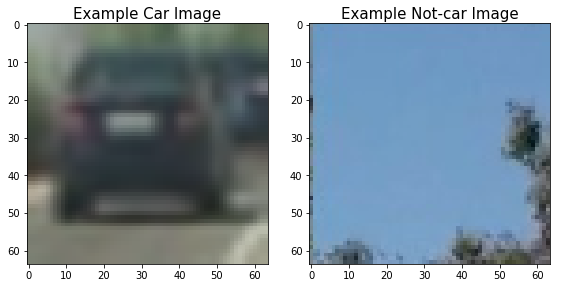

In [1]:
%matplotlib inline 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

#from skimage.feature import hog
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles
notcars = glob.glob('data/non-vehicles/*/*.png')
cars = glob.glob('data/vehicles/*/*.png')

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = 0#np.random.randint(0, len(cars))
notcar_ind =0# np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('Example Car Image', fontsize=15)
ax2.imshow(notcar_image)
ax2.set_title('Example Not-car Image', fontsize=15)
plt.savefig('output_images/car_and_notcar')

## Feature Extraction Helper Functions

In [2]:
# Jupyter notebook inline drawing
# This imports the bbox library in bbox.py where all utility helper functions are implemented
import bbox

In [3]:
# create the bbox instance
bbox = bbox.bbox()

## Feature Extraction

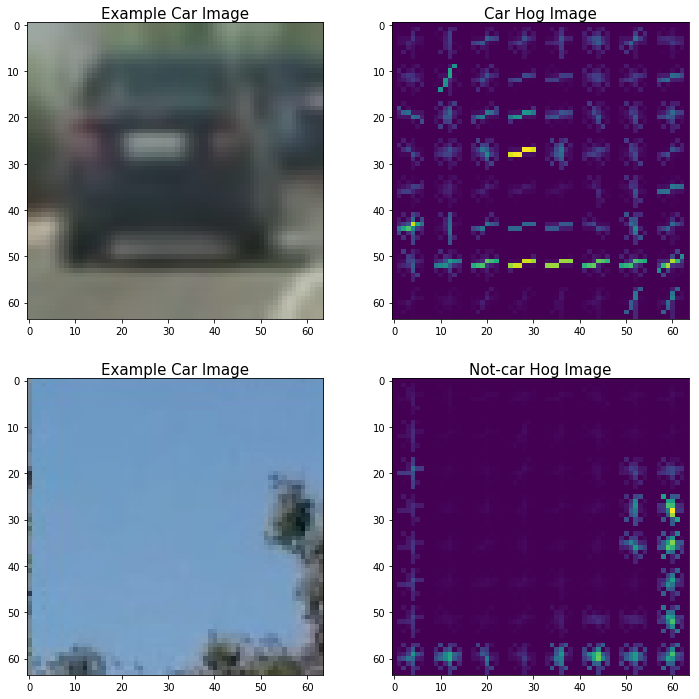

In [8]:
#car:
# apply color conversion 
feature_image = bbox.convert_color(car_image, conv="RGB2YCrCb")

# Apply bin_spatial() to get spatial color features
spatial_features = bbox.bin_spatial(feature_image, size=(bbox.spatial_size,bbox.spatial_size))

# Apply color_hist() also with a color space option now
hist_features = bbox.color_hist(feature_image, nbins=bbox.histbin, bins_range=bbox.hist_range)

# Compute individual channel HOG features for the entire image
hog1, hog1_vis = bbox.get_hog_features(feature_image[:,:,0], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, vis=True, feature_vec=False)
hog2, hog2_vis= bbox.get_hog_features(feature_image[:,:,1], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, vis=True, feature_vec=False)
hog3, hog3_vis= bbox.get_hog_features(feature_image[:,:,2], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, vis=True, feature_vec=False)

f, axarr = plt.subplots(2, 2, figsize=(12, 12))
axarr[0,0].imshow(car_image)
axarr[0,0].set_title('Example Car Image', fontsize=15)
axarr[0,1].imshow(hog1_vis)
axarr[0,1].set_title('Car Hog Image', fontsize=15)

#car:
# apply color conversion 
feature_image = bbox.convert_color(notcar_image, conv=bbox.colorspace)

# Apply bin_spatial() to get spatial color features
spatial_features = bbox.bin_spatial(feature_image, size=(bbox.spatial_size,bbox.spatial_size))

# Apply color_hist() also with a color space option now
hist_features = bbox.color_hist(feature_image, nbins=bbox.histbin, bins_range=bbox.hist_range)

# Compute individual channel HOG features for the entire image
hog1, hog1_vis = bbox.get_hog_features(feature_image[:,:,0], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, vis=True, feature_vec=False)
hog2, hog2_vis= bbox.get_hog_features(feature_image[:,:,1], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, vis=True, feature_vec=False)
hog3, hog3_vis= bbox.get_hog_features(feature_image[:,:,2], bbox.orient, bbox.pix_per_cell, bbox.cell_per_block, vis=True, feature_vec=False)

axarr[1,0].imshow(notcar_image)
axarr[1,0].set_title('Example Car Image', fontsize=15)
axarr[1,1].imshow(hog1_vis)
axarr[1,1].set_title('Not-car Hog Image', fontsize=15)
plt.savefig('output_images/hog_RGB2YCrCb')

In [12]:
car_features = bbox.extract_features(cars)
# notcar_features = bbox.extract_features(notcars)

## Train SVM Classifier

In [13]:
bbox.train_svm(cars, notcars)

45.77 Seconds to extract HOG features...
Using spatial binning of: 16 and 10 histogram bins
Number of training data: 14208 testing data: 3552
Feature vector length: 2562
11.47 Seconds to train SVC...
Test Accuracy of SVC =  0.9803
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  0.  0.  1.  0.]
0.00361 Seconds to predict 10 labels with SVC


## Sliding Window Search

In [14]:
bbox.get_param()

# Bounding box list to save box (x,y) in sliding windowed searching
bbox_list=[]

images = glob.glob('examples/*')

test_scales = [1.5,1.3,2.0,2.2]

fig = plt.figure(figsize=(25,25))
for idx, f in enumerate(images):
    img = mpimg.imread(f)
    for scale in test_scales:
        bbox_list = bbox.find_cars(img, scale, bbox_list)
        out_img = bbox.draw_bboxes(img,bbox_list)
        a = fig.add_subplot(1,6,idx+1)
        a.axis('off')
        plt.imshow(out_img)
        bbox_list=[]

(1150, 610, 4)
nxsteps:  21
nysteps:  6
ch1.shape:  (170, 406)
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]
[ 1.]


SystemError: new style getargs format but argument is not a tuple

## Heatmap and labelledbounding box

In [ ]:
### Heatmap and labelledbounding box

# Heat map
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = bbox.add_heat(heat,bbox_list)

# Apply threshold to help remove false positives
heat = bbox.apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Label bounding box
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = bbox.draw_labeled_bboxes(np.copy(img), labels)

# Show heat map
plt.imshow(heatmap)
plt.show()

# Show labelled image
plt.imshow(draw_img)
plt.show()
plt.savefig('output_images/sliding_window_1')

## Test on Videos

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Vehicle detection pipeline
def bbox_pipeline(bbox, img, bbox_list=[]):
    '''
    Processing vehicle detection and bounding box.
    '''
    img = np.copy(img)

    # Do multi-scale searching
    scale = 1.0
    bbox_list = bbox.find_cars(img, scale, bbox_list)
    scale = 1.5
    bbox_list = bbox.find_cars(img, scale, bbox_list)
    scale = 2.0
    bbox_list = bbox.find_cars(img, scale, bbox_list)
    
    ### Heatmap and labelledbounding box
    # Heat map
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = bbox.add_heat(heat,bbox_list)
    # Apply threshold to help remove false positives
    heat = bbox.apply_threshold(heat,5)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Label bounding box
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    img = bbox.draw_bboxes(img, bbox_list)
    draw_img = bbox.draw_labeled_bboxes(img, labels)
    # To view the heatmap boxes?
    #draw_img = np.array(np.dstack((heatmap, heatmap, heatmap))*255, dtype='uint8')
    # Alpha blending
    draw_img = cv2.addWeighted(draw_img, 0.9, img, 0.1, 0) 

    # Searching window (big and small)
    s_win = ((bbox.xstart_s,bbox.ystart_s), (bbox.xstop_s,bbox.ystop_s))
    b_win = ((bbox.xstart,bbox.ystart), (bbox.xstop,bbox.ystop))
    cv2.rectangle(draw_img, s_win[0], s_win[1], (0,0,255), 2)
    cv2.rectangle(draw_img, b_win[0], b_win[1], (0,0,255), 2)

    return draw_img

In [ ]:
project_output = 'project_output.mp4'
FILE = 'test_video.mp4'
# clip = VideoFileClip("test_video.mp4")
# # clip = VideoFileClip("project_video.mp4")

# white_clip = clip.fl_image(bbox_pipeline) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(project_output, audio=False)

clip = cv2.VideoCapture(FILE)
fourcc = cv2.VideoWriter_fourcc(*'X264')

frame_cnt = 0
frame_start = 0
frame_end = 0xffffffff
#frame_end = 50

out=None

# Vehicle detector
bbox.get_param()
bbox_list = []

# Search as if from start of frame
detected = False

while True:
    flag, image = clip.read()
    bbox_list = []
    if flag:
        frame_cnt += 1
        if frame_cnt < frame_start:
            continue
        elif frame_cnt > frame_end:
            break
        print('frame_cnt = ', frame_cnt)
        if out == None:
            out = cv2.VideoWriter(project_output, fourcc, 30.0, (image.shape[1]//2, image.shape[0]//2))

        # Vehicle detection pipeline
        res = bbox_pipeline(bbox, image, bbox_list)

        # Resize
        res = cv2.resize(res, (res.shape[1]//2, res.shape[0]//2))
        # Write video out
        cv2.imshow('video', res)
        out.write(res)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break




In [ ]:
project_output